# Heteroplasmies in RNA-seq (snyder 20 time points)

> This IPython notebook replicates the analyses shown in Rebolledo-Jaramillo, Su,  et al (2014) *Maternal Age Effect and Severe Germline bottleneck in the Inheritance of mitochondrial DNA heteroplasmy*  [**PNAS October 28, 2014 vol. 111 no. 43 15474-15479**](http://www.pnas.org/content/111/43/15474.abstract)

> - One individual, 20 timepoints from blood samples
> - Combination of Python and R scripts to replicate the results shown in the PNAS publication.

# Import necessary python modules

Module |  Description
-------|-------------
[pandas](http://pandas.pydata.org/) | Library providing high-performance, easy-to-use data structures and data analysis tools 
[numpy](http://www.numpy.org/) | Package for scientific computing with Python
[itertools](https://docs.python.org/2/library/itertools.html) | Functions creating iterators for efficient looping

In [1]:
import pandas as pd
import numpy as np
import itertools

# Get input data from the history. 
><i class="icon-pencil"> In this case, the allele counts are located in history item 1. To access it use "get(1)". </i>

><i class="icon-exclamation"> You need to adjust the history item to your own case when needed.

In [2]:
!ls ../data

chrM_2617.brain.counts		 RNA_2617.txt
chrM_2617.counts		 snyder_phenotype.txt
GTEX_sample_info_phenotypes.txt  snyder_rnaseq_20_timepoints.counts
phenotypes.txt			 snyder_RNAseq_2617.txt
rCRS.gb				 snyder_RNAseq_real_heteroplasmies.txt


In [3]:
tissue = "Snyder"

allelecounts="../data/snyder_rnaseq_20_timepoints.counts"
#sampleName = allelecounts.split(".")[0].split("-")[1]
#hq_out = "%s_hq_sites.txt" % sampleName
#annotated_out = "%s_annotated_hq_sites.txt" % sampleName

><i class="icon-pencil"> Pandas can read tabular data directly into a dataframe. We will look at the first line of the data to identify a potential header line, and add the option accordingly to the pandas "read_table" method. 

In [4]:
with open(allelecounts) as ac:
    first_line = ac.readline()
    if first_line.startswith("#"):
        df = pd.read_table(allelecounts)
    else:
        df = pd.read_table(allelecounts,header=None)

# Prepare data
><i class="icon-pencil"> If a header is present, Pandas will assign the column names automatically, however we will standardize the column names to ease access later .

In [5]:
df.columns=["sample","reference","position","A","C","G","T","a","c","g","t","cvrg","nalleles","major","minor","maf"]

In [6]:
df.head()

,sample,reference,position,A,C,G,T,a,c,g,t,cvrg,nalleles,major,minor,maf
0,SRR353635,chrM,1,0,0,332,0,0,0,0,0,332,0,G,.,0
1,SRR353635,chrM,2,326,0,0,0,0,0,0,0,326,0,A,.,0
2,SRR353635,chrM,3,0,0,0,330,0,0,0,0,330,0,T,.,0
3,SRR353635,chrM,4,0,351,0,0,0,0,0,0,351,0,C,.,0
4,SRR353635,chrM,5,346,0,0,0,0,0,0,0,346,0,A,.,0


# Figure: samples sequencing depth distribution

><i class="icon-pencil">At this point we can calculate the coverage distribution of each sample, as shown in Figure S7 in the PNAS paper.</i>

>To do so, we need to make the df object available to R (via [Rpy2](http://rpy.sourceforge.net/)).


><i class="icon-pencil"> [Rmagic](http://rpy.sourceforge.net/rpy2/doc-2.4/html/interactive.html#module-rpy2.ipython.rmagic) is an extension of IPython designed to run R code. </i>

><i class="icon-exclamation"> Rmagic needs to be loaded before any work with R code can be done.</i>

In [7]:
%load_ext rpy2.ipython

><i class="icon-exclamation"> Rmagic usage specifics: </i>

One line R code |  Block of R code
----------------|-----------------
%R|%%R


><i class="icon-pencil"> Python objects are passed onto R (as data frames with headers) with the **-i** flag</i>

In [8]:
%R -i df

><i class="icon-pencil"> Transform numeric looking columns into actual numeric columns to guarantee the value types</i>

In [9]:
%%R
tonumeric = c(3:13,16)
df[,tonumeric] = apply(df[,tonumeric], 2, function(x) as.numeric(as.character(x)))


><i class="icon-pencil"> Define custom R function to generate coverage figure</i>

In [10]:
%%R
boxPlotCvrg = function(data,tissue){
    
    #names = sort(unique(data[["sample"]]))
    #data[["sample"]] = factor(data[["sample"]],levels=names)
    
    meds = aggregate(data$cvrg, by=list(data$sample),FUN=median)
    ordered = as.character(meds[order(-meds$x),]$Group.1)

    
    data[["sample"]] = factor(data[["sample"]],levels=ordered)
    MIN = floor(min(log10(data$cvrg+1)))
    MAX = ceiling(max(log10(data$cvrg+1)))
    

    boxplot(log10(cvrg)~sample,data=data,whisklty="solid",outcol=rgb(255,99,71,50,maxColorValue=255),pch=16,
            whisklwd=2,boxlwd=1,medlwd=1,medcol="black",main="",
            xlab=expression(paste("log"[10],"(coverage)",sep="")),bty="n",frame=F,boxcol="black",
            boxfill="azure3",medlwd=4,whiskcol="grey",staplecol="grey",ylim=c(MIN,MAX),
            cex.axis=1,horizontal=TRUE,xaxt="n",cex.lab=2)
    
    mtext(tissue,adj=0,side=3,las=1,at=(MAX+1)/2,font=2,cex=2)
    axis(1,at=MIN:MAX,cex.axis=2,las=1)
    }

### Plot
><i class="icon-pencil"> You can adjust the size of the plotting image by adjusting:</i>

width|height|units|resolution
-----|------|-----|----------
-w|-h|-u|-r

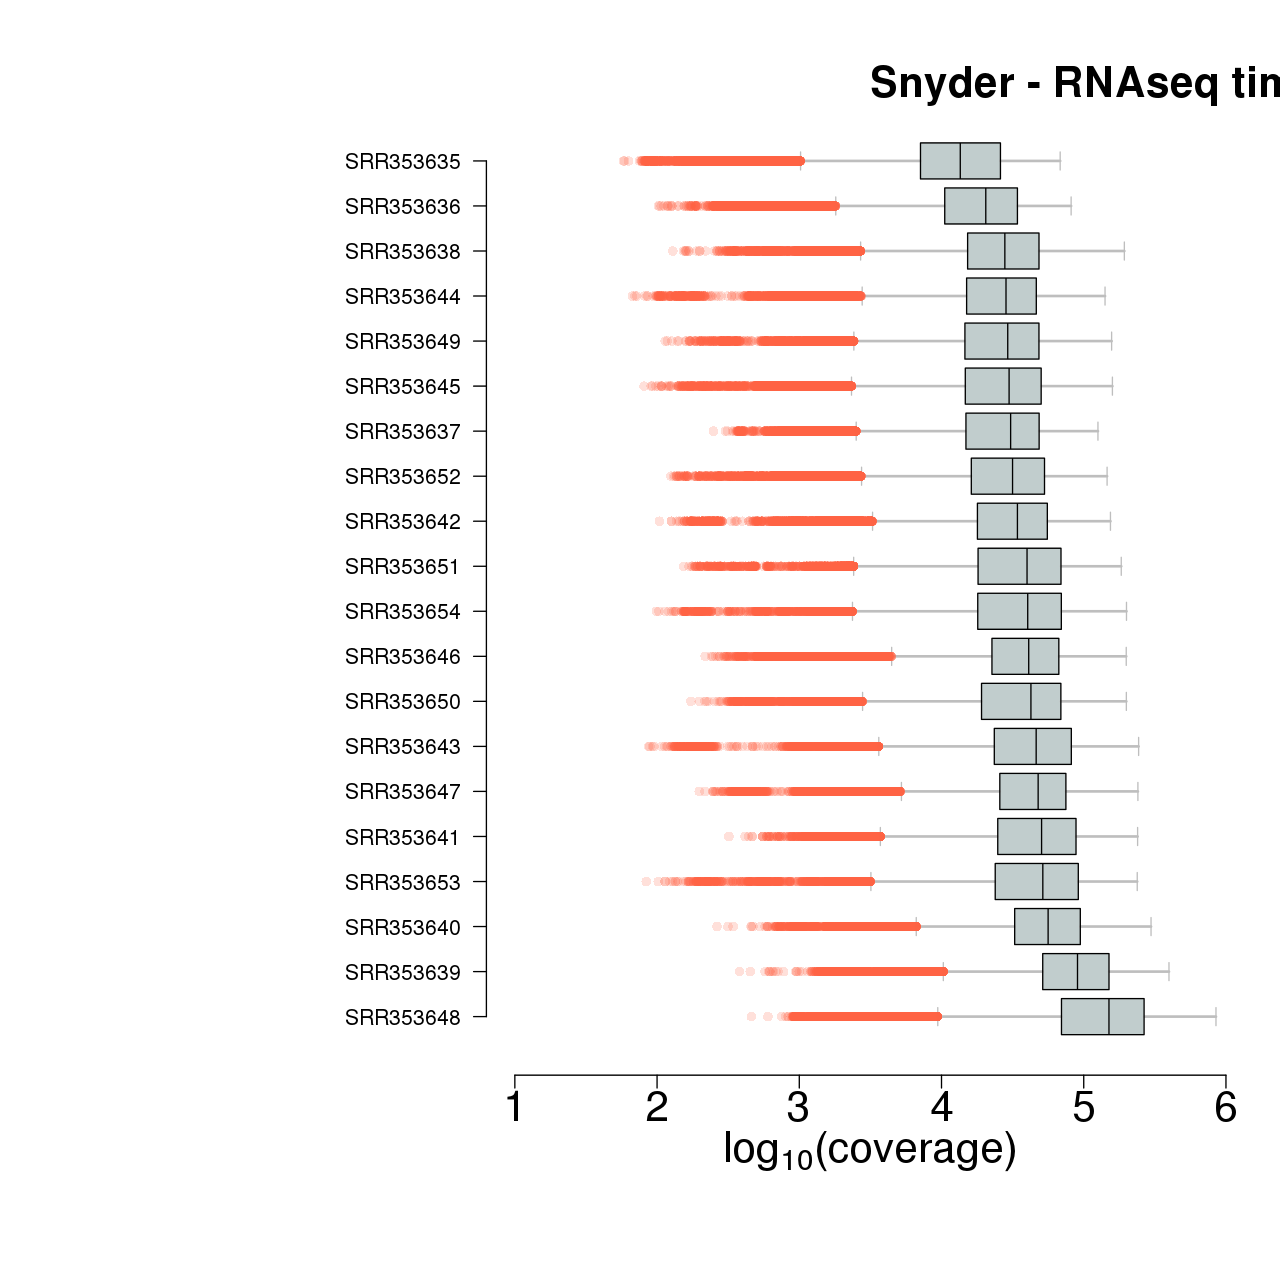

In [11]:
%%R -w 10 -h 10 -u in -r 128

par(las=2)
par(mar=c(6,17,4,1))
par(oma=c(2,2,0,0))
#par(mfrow=c(2,1))
#par(cex.lab=1.25)
#par(cex.axis=0.75)

boxPlotCvrg(df,"Snyder - RNAseq time points")


In [12]:
df.head()

,sample,reference,position,A,C,G,T,a,c,g,t,cvrg,nalleles,major,minor,maf
0,SRR353635,chrM,1,0,0,332,0,0,0,0,0,332,0,G,.,0
1,SRR353635,chrM,2,326,0,0,0,0,0,0,0,326,0,A,.,0
2,SRR353635,chrM,3,0,0,0,330,0,0,0,0,330,0,T,.,0
3,SRR353635,chrM,4,0,351,0,0,0,0,0,0,351,0,C,.,0
4,SRR353635,chrM,5,346,0,0,0,0,0,0,0,346,0,A,.,0


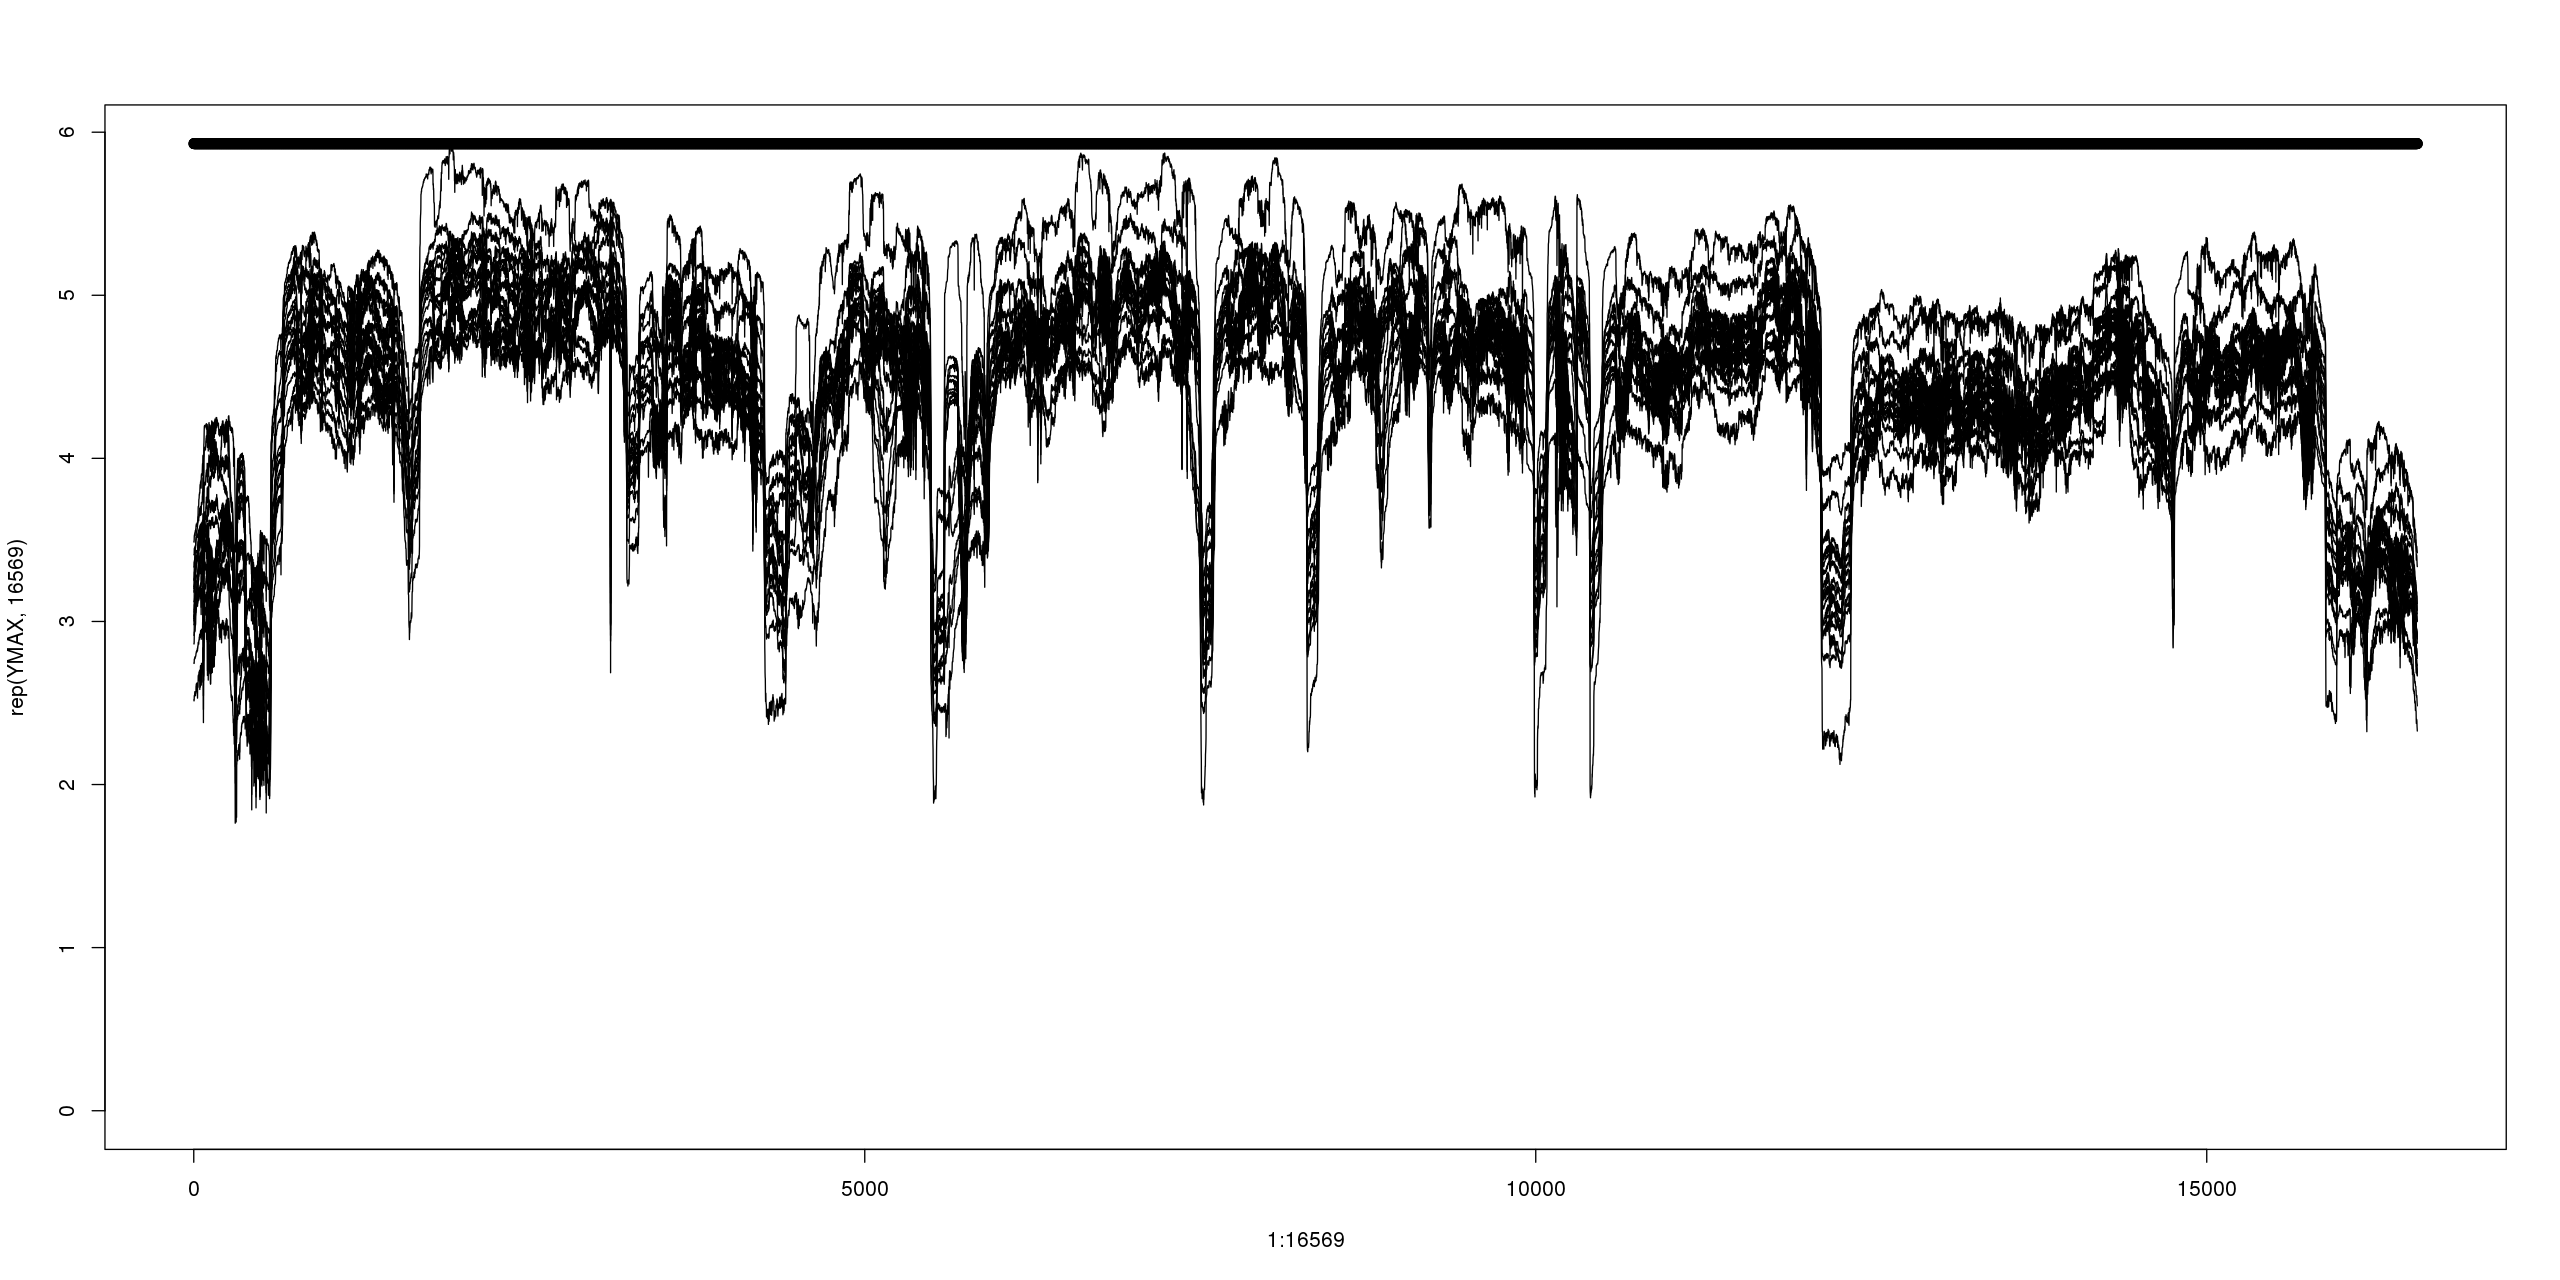

In [13]:
%%R -w 20 -h 10 -u in -r 128

YMAX = log10(max(df$cvrg))

plot(1:16569,rep(YMAX,16569),ylim=c(0,YMAX),plot=F)

for (sample in unique(df$sample)){
    current = df[df$sample==sample,]
    lines(current$pos,log10(current$cvrg))
}

In [14]:
%%R

# average median coverage of samples
bp = boxplot(cvrg~sample,data=df,plot=FALSE)
stats = cbind(bp$n,bp$stats[3,])
Nsamples = nrow(stats)
meanSites = floor(mean(stats[,1]))
meanCvrg = floor(mean(stats[,2]))
cbind(c("Nsamples","Nsites","Cvrg"),c(Nsamples,meanSites,meanCvrg))

     [,1]       [,2]   
[1,] "Nsamples" "20"   
[2,] "Nsites"   "16569"
[3,] "Cvrg"     "45145"


# Identification of high quality heteroplasmic sites

 ><i class="icon-pencil"> We defined high quality (HQ):</i>
 
 >1. minor allele frequency (maf) ≥ 1%
 >2. coverage ≥ 1000
 >3. maf balance (1% in forward and reverse strands)
 >4. no strand bias
 >5. outside "problematic sites":
     - mtDNA homopolymeres
     - around the artificial "N" at position 3107
     - within 50 bp of the long range PCR primers


><i class="icon-pencil"> Back in Python, we define the "problematic sites" ranges...</i>

In [15]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC

In [16]:
rCRS = SeqIO.read(open("../data/rCRS.gb","r"), "genbank")
genedb = dict()
labs = ["class","start","end","strand"]
for feature in rCRS.features:
    if feature.type in ["rRNA","tRNA","CDS"]:
        ftype = feature.type
        name = feature.qualifiers['gene'][0]
        start = int(feature.location.start)
        end = int(feature.location.end)
        strand = int(feature.location.strand)
        genedb[name] = dict(zip(labs,[ftype,start,end,strand]))
genedb['D-loop1'] = dict(zip(labs,["Dloop",0,576,1]))
genedb['D-loop2'] = dict(zip(labs,["Dloop",16023,16569,1]))

In [17]:
#mask_trna = []
#annotated = []
#for region in genedb:
#    start = genedb[region]['start']
#    end = genedb[region]['end']
#    annotated+=range(start,end)
#    
#    if genedb[region]['class']=="tRNA":
#        mask_trna+=range(start,end)
#        
#noncoding = [i for i in range(16569) if i not in annotated]
#mask2 = mask_trna+noncoding


In [18]:
coding_rrna = []
for region in genedb:
    start = genedb[region]['start']
    end = genedb[region]['end']
    
    if genedb[region]['class'] in ["rRNA","CDS"]:
        coding_rrna+=range(start,end)

><i class="icon-pencil"> ... and filter the main dataframe **partially** on maf, coverage and position</i>

In [19]:
hq_sites = df[(df.maf>=0.01) & (df.cvrg>=1000) & df.position.isin(coding_rrna)]

In [20]:
len(hq_sites)

2164

><i class="icon-pencil"> By applying these initial filters, we reduced the dataframe from ~300,000 lines to 572 lines only, which is much more manageable.</i>


> <i class="icon-pencil"> Next, we calculate strand bias and maf balance on these 572 sites... </i>


In [21]:
def strand_stats(x, mafThreshold=0.01):
    falleles = ['A','C','G','T']
    ralleles = ['a','c','g','t']
    sample,position,major,minor,coverage,maf = x[['sample','position','major','minor','coverage','maf']]
    fcounts = x[falleles]
    rcounts = x[ralleles]
    if minor!='.':
        index_major = falleles.index(major)
        index_minor = falleles.index(minor)

        fcount_minor = float(fcounts[index_minor])
        ftotal = fcount_minor + fcounts[index_major]
        
        rcount_minor = float(rcounts[index_minor])
        rtotal = rcount_minor + rcounts[index_major]
        
        minor_total = float(fcount_minor + rcount_minor)
        site_total = ftotal + rtotal

        try:
            strandBias = abs( (fcount_minor/ftotal) - (rcount_minor/rtotal) ) / (minor_total/site_total)
        except:
            strandBias = np.nan
            
        try:
            maf_frwd = fcount_minor/sum(fcounts)
        except:
            maf_frwd = np.nan
        try:
            maf_rvrs = rcount_minor/sum(rcounts)
        except:
            maf_rvrs = np.nan
            
        if (maf_frwd>=mafThreshold) and (maf_rvrs>=mafThreshold):
            mafBalance = 1
        else:
            mafBalance = 0
    else:
        strandBias = float(2)
        mafBalance = 0

    return pd.Series([strandBias,mafBalance])

In [22]:
biasCols = hq_sites.apply(strand_stats,axis=1,args=(0.01,))
biasCols.columns = ["strandBias","mafBalance"]
hq_sites = pd.concat([hq_sites,biasCols],axis=1)

> <i class="icon-pencil">... and filter them on maf balance and strand bias 

In [23]:
hq_sites = hq_sites[(hq_sites.strandBias<=1) & (hq_sites.mafBalance==1) ]
len(hq_sites)

188

In [24]:
from scipy.stats import poisson

In [25]:
def poisson_pval(current_df,sample):
    alleles = ['A','C','G','T','a','c','g','t']
    current_counts = list(current_df.loc[current_df['sample']==sample, alleles].iloc[0,:])
    others_counts = list(current_df.loc[current_df['sample']!=sample, alleles].apply(sum,axis=0))
    site_error = (sum(others_counts) - max(others_counts))/float(sum(others_counts))
    current_nonMajor_counts = int(sum(current_counts)-max(current_counts))
    current_coverage = sum(current_counts)
    pvalue = poisson.pmf(current_nonMajor_counts, site_error*current_coverage)
    return pvalue

In [26]:
poisson_pvalues = []

for s,p in hq_sites[["sample","position"]].itertuples(index=False):
    poisson_pvalues.append(poisson_pval(df[df['position']==p],s))


In [27]:
hq_sites["poisson"]=poisson_pvalues
hq_sites = hq_sites[hq_sites.poisson<=0.05]
len(hq_sites)

188

> <i class=icon-exclamation> There is an additional screenning step not shown here, where we calculate the cycle bias of the site, i.e. whether the alternative allele is supported primarily by nucleotides within 25 bp of the read ends. </i> 


# Screening for contamination
> In our previous publication, Dickins, Rebolledo-Jaramillo, et al (2014) Controlling for contamination in resequencing studies with a reproducible web-based phylogentic approach [BioTechniques, 56(3):134–141](http://goo.gl/jv2J34), we described signs of potential contamination:
 1. Many heteroplasmic sites (≥5 per sample)
 2. Tigh minor allele frequency distribution
 3. Non-family related positions
 
> <i class="icon-pencil"> We routinely apply our contamination detection pipeline, so we are confident our sites in the PNAS paper were not artifacts. As an example of the screening for contamination, we can plot the number of sites and the minor allele frequency distribution of all samples in the high quality sites set

In [28]:
# Make R aware of the hq_sites dataframe
%R -i hq_sites

In [29]:
%%R

# Adjust value types in the hq_sites dataframe

tonumeric = c(3:13,16:18)
hq_sites[,tonumeric] = apply(hq_sites[,tonumeric], 2, function(x) as.numeric(as.character(x)))
#head(hq_sites,2)

In [30]:
#%%R

#meds = aggregate(hq_sites$maf, by=list(hq_sites$sample),FUN=function(x) length(x))
#ordered = as.character(meds[order(-meds$x),]$Group.1)
#hq_sites$sample = factor(hq_sites$sample,levels=ordered)


In [31]:
%%R

rev(levels(hq_sites$sample))

 [1] "SRR353654" "SRR353653" "SRR353652" "SRR353651" "SRR353650" "SRR353649"
 [7] "SRR353648" "SRR353647" "SRR353646" "SRR353645" "SRR353644" "SRR353643"
[13] "SRR353642" "SRR353641" "SRR353640" "SRR353639" "SRR353638" "SRR353637"
[19] "SRR353636" "SRR353635"


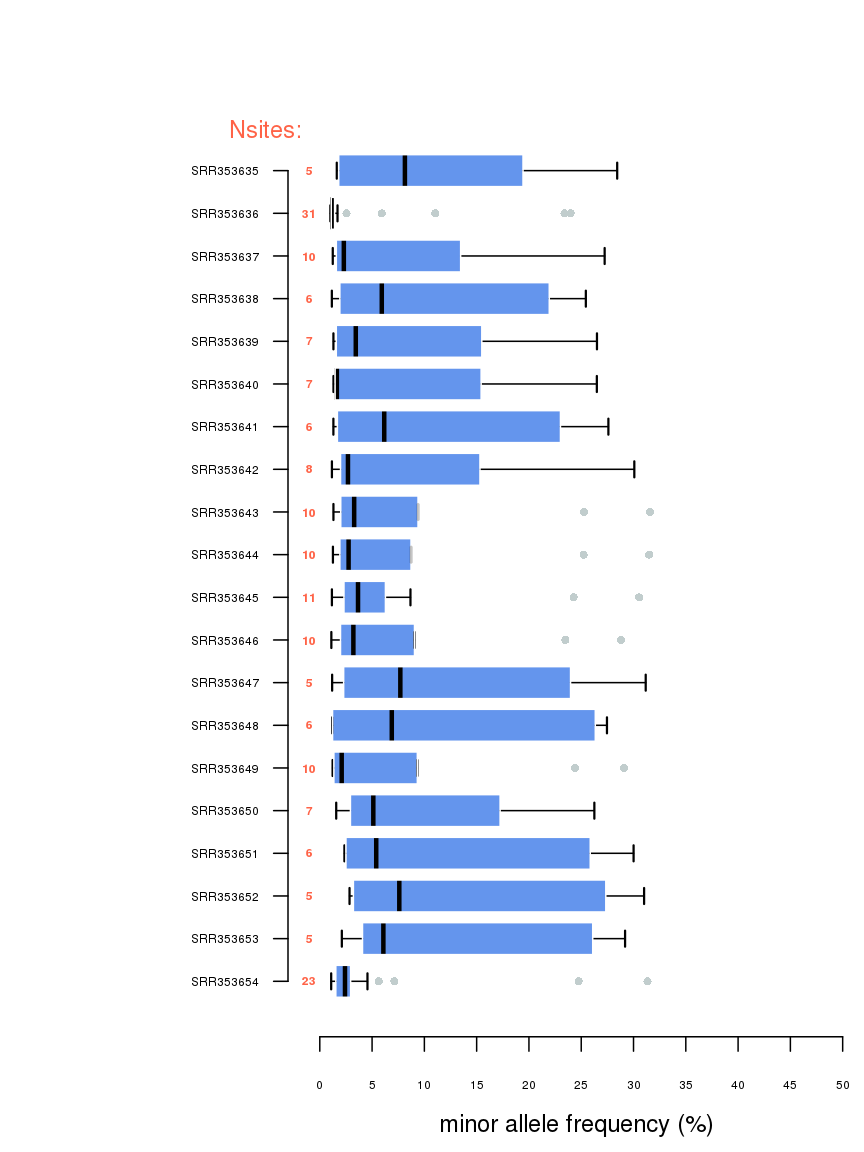

In [32]:
%%R -w 6 -h 8 -u in -r 144

# Plot hq_sites number of sites and minor allele frequency distribution
hq_sites$sample = factor(hq_sites$sample,levels=rev(levels(hq_sites$sample)))


par(mar=c(4,10,4,0))
boxplot(
  maf~sample,
  data=hq_sites,
  pch=16,cex=0.75,
  outcol="azure3",outline=T,
  whisklty=1,whiskwd=1.5,
  staplelwd=1.5,
  boxwex=0.75,boxcol="white",boxfill="cornflowerblue",
  horizontal=T,cex.axis=0.5,las=2,
  frame=F,xaxt="n",ylim=c(-0.01,0.5)
  )

axis(1,at=seq(0,5,0.5)/10,lab=100*(seq(0,5,0.5)/10),cex.axis=0.5)
title(xlab="minor allele frequency (%)",line=2.5,cex.axis=0.75)

nsites = table(hq_sites[["sample"]])
for (i in 1:length(nsites)){
  text(-0.01,i,lab=nsites[i],cex=0.5,font=2,col="tomato")
}
mtext("Nsites:",side=3,line=-1,at=0,adj=1.25,col="tomato")

# Tabulating high quality sites

> <i class="icon-pencil"> For each high quality site, we can retrieve the minor allele frequency information for the remaining samples in the collection. </i>

In [33]:
unique_positions = hq_sites["position"].drop_duplicates()
len(unique_positions)

68

In [34]:
hq_sites.sort_values(by=["position"])

,sample,reference,position,A,C,G,T,a,c,g,t,cvrg,nalleles,major,minor,maf,strandBias,mafBalance,poisson
17294,SRR353636,chrM,726,190,17893,30,3,52,4651,10,0,22829,0,C,A,0.01060,0.051755,1,0.000000e+00
17485,SRR353636,chrM,917,149,10847,26,0,194,15080,31,3,26330,0,C,A,0.01303,0.065029,1,0.000000e+00
316698,SRR353654,chrM,1888,53529,103,898,10,96466,15,1157,10,152188,4,A,G,0.01350,0.343866,1,1.532548e-44
316908,SRR353654,chrM,2098,1477,17,93987,29,1057,14,73580,39,170200,4,G,A,0.01489,0.087932,1,1.883485e-210
35266,SRR353637,chrM,2129,624,4,35672,1,433,1,33355,3,70093,4,G,A,0.01508,0.290201,1,1.209193e-06
234094,SRR353649,chrM,2129,770,2,47032,1,746,2,63966,0,112519,0,G,A,0.01347,0.339925,1,2.372592e-231
18734,SRR353636,chrM,2166,227,18989,59,2,431,36604,72,5,56389,4,C,A,0.01167,0.014997,1,1.145375e-124
18831,SRR353636,chrM,2263,344,31898,37,7,237,20116,31,4,52674,4,C,A,0.01103,0.088276,1,1.987401e-202
18852,SRR353636,chrM,2284,331,28450,45,10,189,15969,29,2,45025,4,C,A,0.01155,0.016969,1,1.931505e-217
18996,SRR353636,chrM,2428,378,29055,55,4,260,20719,37,1,50509,4,C,A,0.01263,0.035508,1,6.228627e-20


In [35]:
from collections import Counter

In [36]:
# tabulate minor allele frequencies for all tissues per position, where at least one of the tissues showed a
# high quality heteroplasmy

tissues = list(df['sample'].drop_duplicates())
columns = ["position","major","minor"]+tissues
heatmap = pd.DataFrame(index=range(len(unique_positions)),columns=(range(len(columns))))
i=-1

for p in unique_positions:
    i+=1
    current = df[df.position==p].loc[:,['sample','position','major','minor','maf']]
    #current2 = current.loc[(current.maf>=0.01)]
    alleles = zip(current.major,current.minor)
    ref = Counter(alleles).most_common()[0][0]

    MAFS=[]
    #for sample in current.iterrows():
    #    tissue,pos,major,minor,maf = list(sample[-1])
    for t in tissues:
        try:
            tissue,pos,major,minor,maf = list(current.loc[current["sample"]==t,].squeeze())
        except:
            tissue,pos,major,minor,maf = [sample,p,".",".","."]
             
        
        if (major,minor) == ref:
            MAF = maf
            
            
        elif (major,minor) == ref[::-1]:
            MAF = 1 - float(maf)
            
            
        else:
            MAF = 'NA'
           
        MAFS.append(MAF)
    
    heatmap.loc[i] = [p]+list(ref)+MAFS

heatmap.columns = columns


In [37]:
heatmap = heatmap[(heatmap.minor!=".")]

In [38]:
%R -i heatmap

In [39]:
%%R
require("gplots")

/home/boris/bin/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: gplots

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/home/boris/bin/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘gplots’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/home/boris/bin/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following object is masked from ‘package:stats’:

    lowess


  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [40]:
%%R
myPalette=colorRampPalette(c("white","cornflowerblue","tomato"))

tmpData = heatmap[,4:ncol(heatmap)]
tmpData = apply(tmpData,2, FUN=function(x) as.numeric(x)*100)
rownames(tmpData)=heatmap$position
tmpData = tmpData[order(as.numeric(rownames(tmpData))),order(as.character(colnames(tmpData)))]
    
    
tmpData2 = apply(tmpData,2, sprintf,fmt="%.2f")
tmpData2[as.numeric(tmpData2)<0.005*100] = ""

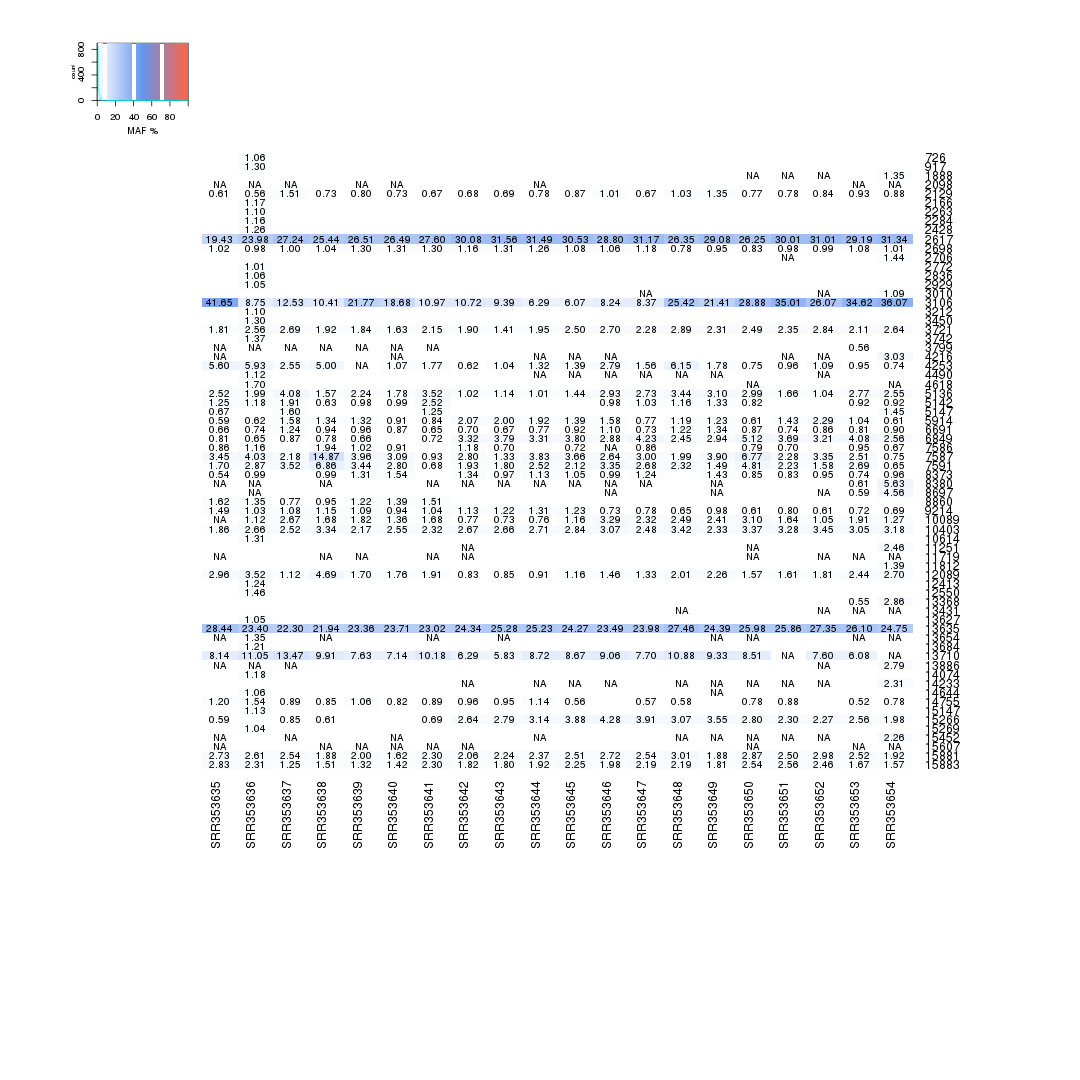

In [41]:
%%R -w 15 -h 15 -u in -r 72
par(oma=c(20,5,2,10))

heatmap.2(tmpData,
          dendrogram="none",
          Colv=F,
          Rowv=F,
          breaks=seq(0*100,1*100,0.01*100),
          trace="none",
          col=myPalette,
          keysize=0.75,
          key.title="",
          key.xlab="MAF %",
          key.ylab="count",
          key.par=list(cex.axis=1),
          margins=c(6,4),
          cexCol=1.25,
          cexRow=1.25,
          cellnote=tmpData2,
          notecol='black',
          notecex=1,
          sepwidth=c(0.01,0.01),
          #rowsep=1:length(uniqPos),
          sepcol="gold",
          #colsep=14
)

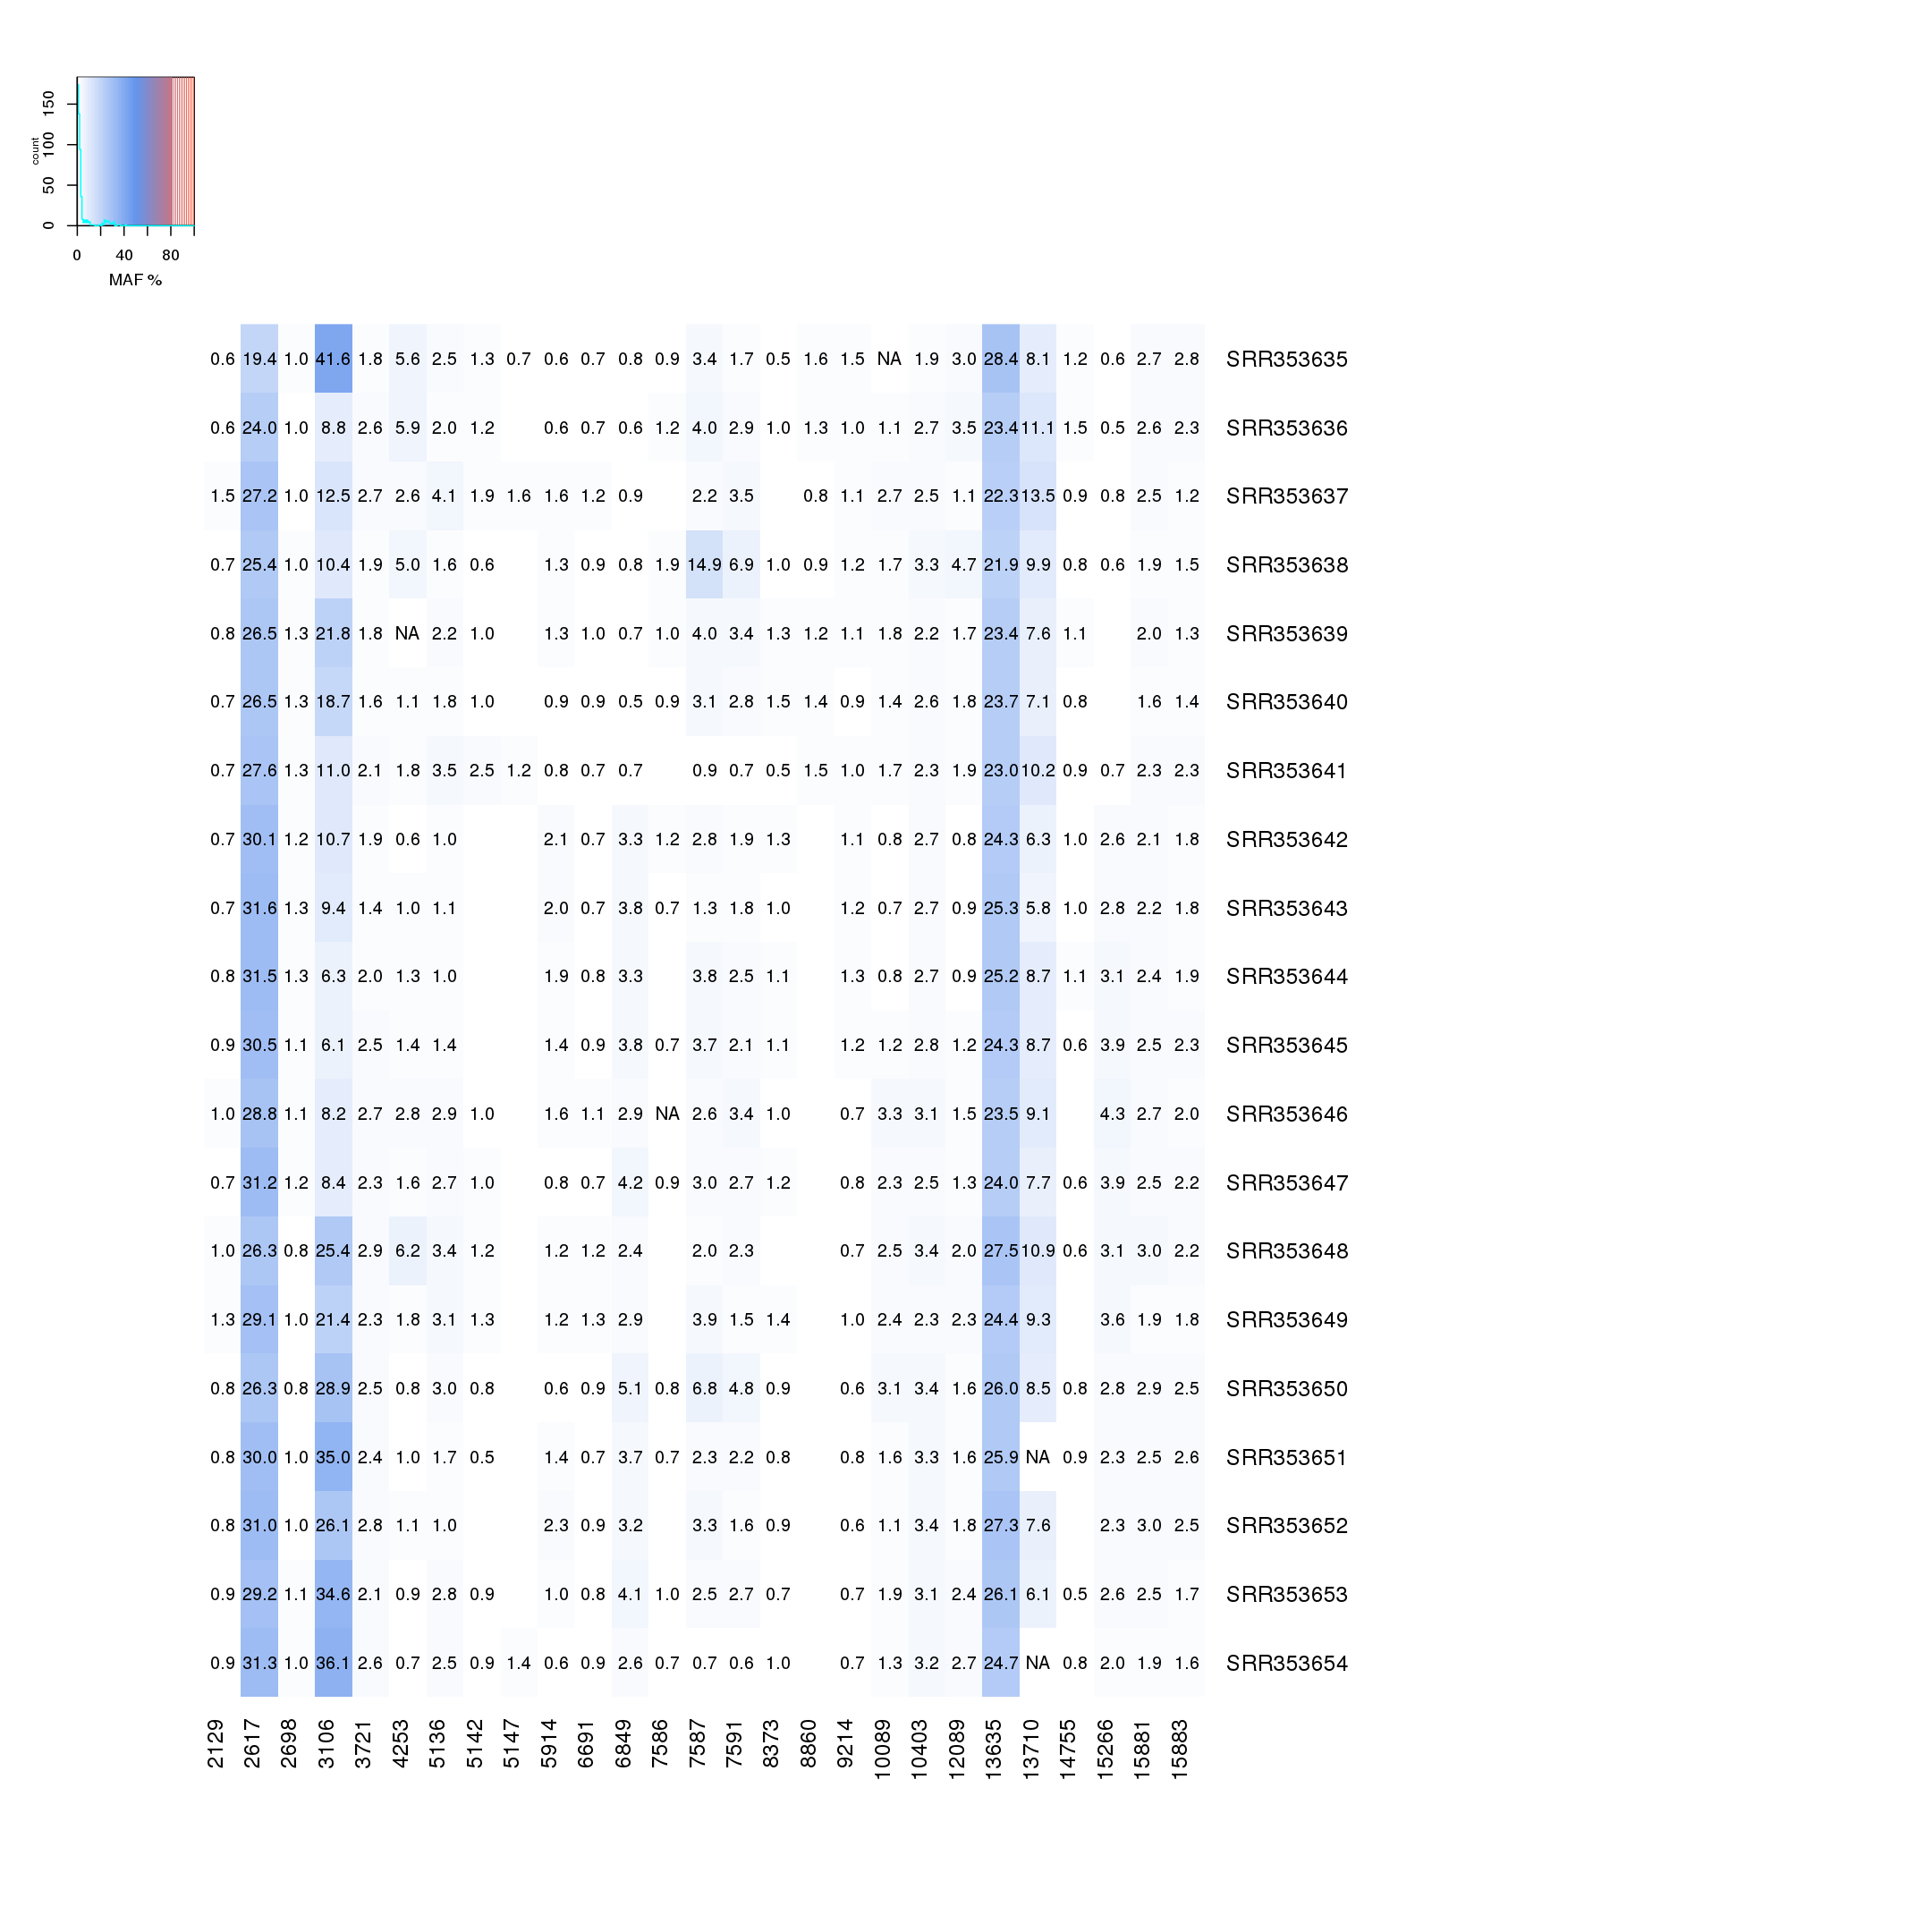

In [42]:
%%R -w 15 -h 15 -u in -r 144
par(oma=c(20,5,2,10))

select=c()
for (r in 1:nrow(tmpData)){
    
    nas = sum(is.na(tmpData[r,]))
    low = sum(tmpData[r,]<0.01*100,na.rm=TRUE)
    
    
#    if ( nas+low <= ncol(tmpData)/3 ) {
#        select = c(select,r)
#    }
#}

    #if ( (ncol(tmpData) - (nas+low)) >= (ncol(tmpData))*0.05  ) {
    if ( (ncol(tmpData) - (nas+low)) >= 2  ) {
        select = c(select,r)
    }
}



selectData=tmpData[select,]
selectData2 = apply(selectData,2, sprintf,fmt="%.1f")
selectData2[as.numeric(selectData2)<0.005*100] = ""



par(oma=c(5,0,2,30))

heatmap.2(t(selectData),
          dendrogram="none",
          Colv=F,
          Rowv=F,
          breaks=seq(0*100,1*100,0.01*100),
          trace="none",
          col=myPalette,
          keysize=0.75,
          key.title="",
          key.xlab="MAF %",
          key.ylab="count",
          key.par=list(cex.axis=1),
          margins=c(6,4),
          cexCol=1.25,
          cexRow=1.25,
          cellnote=t(selectData2),
          notecol='black',
          notecex=1,
          sepwidth=c(0.01,0.01),
          #rowsep=1:length(uniqPos),
          sepcol="gold",
          #colsep=14
)



In [43]:
%%R

bxData = t(selectData)[,seq(nrow(selectData),1)]

labs=c()
for (pos in colnames(bxData)){
    alleles = heatmap[heatmap$position==as.numeric(pos),2:3]
    lab = paste(alleles$major,pos,alleles$minor,sep="")
    labs=c(labs,lab)
}


In [44]:
%%R

# make NA cells with MAF < 1%
#back = bxData
bxData = back

#bxData[as.numeric(bxData)<0.01*100] = NA


Error in withVisible({ : object 'back' not found


/home/boris/bin/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in withVisible({ : object 'back' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/home/boris/bin/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: In addition: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/home/boris/bin/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: There were 28 warnings (use warnings() to see them)
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/home/boris/bin/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 

  res = super(Function, self).__call__(*new_args, **new_kwargs)


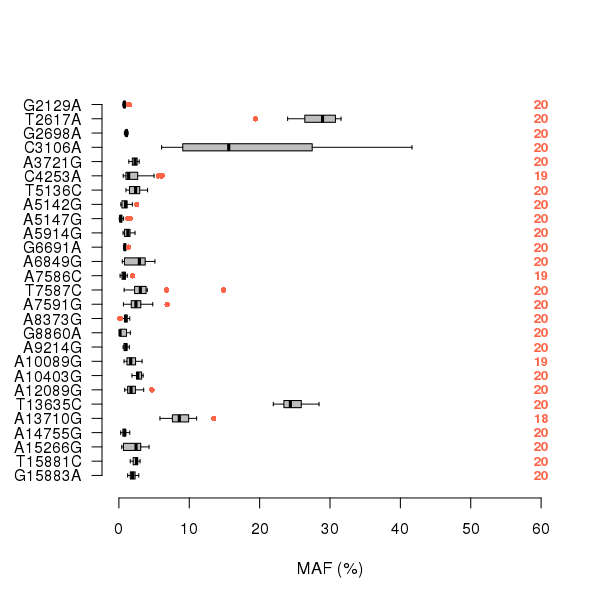

In [68]:
%%R -w 6 -h 6 -u in -r 100

par(oma=c(0,1,0,0))
CAXIS = 1 - (ncol(bxData)/500)

boxplot(bxData,las=1, frame=F, whisklty=1,col="grey",boxwex=0.5, xlab="MAF (%)",xlab="",
        cex.axis=CAXIS,pch=16,cex=0.75,outcol="tomato",ylim=c(0,60), names=labs,horizontal=T)


# Count the number of sites > 1% per site
notna = apply(bxData,2,FUN = function(x) sum(!(is.na(x))))

    
for (i in 1:length(notna)){
  text(60,i,lab=notna[i],cex=0.75,font=2,col="tomato")
}

### <i class="icon-exclamation" > We can add even more information to the quartets table. For instance, the impact of the alternative allele and the nucleotide change class </i>

In [46]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC

In [47]:
def translate(sequence,gene):
    if len(str(sequence))%3!=0:
        add=3 - (len(str(sequence))%3)
    else:
        add=0

    if genedb[gene]["strand"]==1:
        modseq=str(sequence)+add*'A'        
    else:
        modseq=str(sequence.reverse_complement())+add*'A'

    try:
        translation=str(Seq(modseq,IUPAC.unambiguous_dna).translate(table=2,cds=True))
    except:
        translation=[]

    return translation

In [48]:
def evoImpact(quartet):
    het,major,minor = quartet
    pos  = int(het)-1
    gene = [g for g in genedb if genedb[g]['end']>=pos>=genedb[g]['start']]
    
    
    if gene:
        Gene=gene[0]

        if Gene in [feature.qualifiers['gene'][0] for feature in rCRS.features if feature.type=="CDS"]:

            majorseq = rCRS.seq.tomutable()
            minorseq = rCRS.seq.tomutable()
            majorseq[pos] = major
            minorseq[pos] = minor
            ref_seq = rCRS.seq[genedb[Gene]["start"]:genedb[Gene]["end"]]
            major_seq = majorseq[genedb[Gene]["start"]:genedb[Gene]["end"]]
            minor_seq = minorseq[genedb[Gene]["start"]:genedb[Gene]["end"]]

            if (translate(ref_seq,Gene)==translate(minor_seq,Gene)):
                ptimpact = "syn"
            else:
                ptimpact = "nonsyn"
        else:
            ptimpact = "-"
        
    else:
        ptimpact = "-"


    ntClass={'pu':['A','G'],'py':['C','T']}
    majorClass=[k for k,v in ntClass.iteritems() if major in v]
    minorClass=[k for k,v in ntClass.iteritems() if minor in v]
    if majorClass==minorClass:
        ntimpact='ts'
    else:
        ntimpact='tv'

    if gene:
        return pd.Series([ptimpact,genedb[gene[0]]['class'],ntimpact,gene[0]])
    else:
        return pd.Series([ptimpact,"noncoding",ntimpact,"noncoding"])

In [49]:
rCRS = SeqIO.read(open("../data/rCRS.gb","r"), "genbank")
genedb = dict()
labs = ["class","start","end","strand"]
for feature in rCRS.features:
    if feature.type in ["rRNA","tRNA","CDS"]:
        ftype = feature.type
        name = feature.qualifiers['gene'][0]
        start = int(feature.location.start)
        end = int(feature.location.end)
        strand = int(feature.location.strand)
        genedb[name] = dict(zip(labs,[ftype,start,end,strand]))
genedb['D-loop1'] = dict(zip(labs,["Dloop",0,576,1]))
genedb['D-loop2'] = dict(zip(labs,["Dloop",16023,16569,1]))

In [50]:
heatmap[["ptchange","class","ntchange","gene"]] = heatmap[['position','major','minor']].apply(evoImpact,axis=1)

In [51]:
heatmap.head(2)

,position,major,minor,SRR353635,SRR353636,SRR353637,SRR353638,SRR353639,SRR353640,SRR353641,...,SRR353649,SRR353650,SRR353651,SRR353652,SRR353653,SRR353654,ptchange,class,ntchange,gene
0,2617,T,A,0.19433,0.23979,0.2724,0.25441,0.26505,0.26493,0.27597,...,0.29076,0.26255,0.30007,0.31012,0.29193,0.31339,-,rRNA,tv,RNR2
1,3721,A,G,0.01809,0.02555,0.02689,0.01918,0.0184,0.01632,0.02145,...,0.02309,0.02494,0.02355,0.02844,0.02108,0.02639,nonsyn,CDS,ts,ND1


In [52]:
def f(x):
    l = [i for i in x if i<0.01 or i=="NA"]
    #return(float(len(x) - len(l) - 7)>=(len(x)-7)*0.05)
    return(float(len(x) - len(l) - 7)>=2)

In [53]:
initial = heatmap.loc[heatmap.apply(f, axis=1), :]

#initial.to_csv(annotated_out,sep="\t")

In [69]:
%%R
#clean = cycleBias$pos[apply(cycleBias[,c(2:ncol(cycleBias))],1,FUN=function(x) mean(x,na.rm=T)<=0.85)]
#cleanbxData = bxData[,colnames(bxData) %in% clean]
cleanbxData = bxData
#cleanLabs = labs[colnames(bxData) %in% clean]
cleanLabs = labs

In [70]:
%%R
labs

 [1] "G15883A" "T15881C" "A15266G" "A14755G" "A13710G" "T13635C" "A12089G"
 [8] "A10403G" "A10089G" "A9214G"  "G8860A"  "A8373G"  "A7591G"  "T7587C" 
[15] "A7586C"  "A6849G"  "G6691A"  "A5914G"  "A5147G"  "A5142G"  "T5136C" 
[22] "C4253A"  "A3721G"  "C3106A"  "G2698A"  "T2617A"  "G2129A" 


### Clean sites

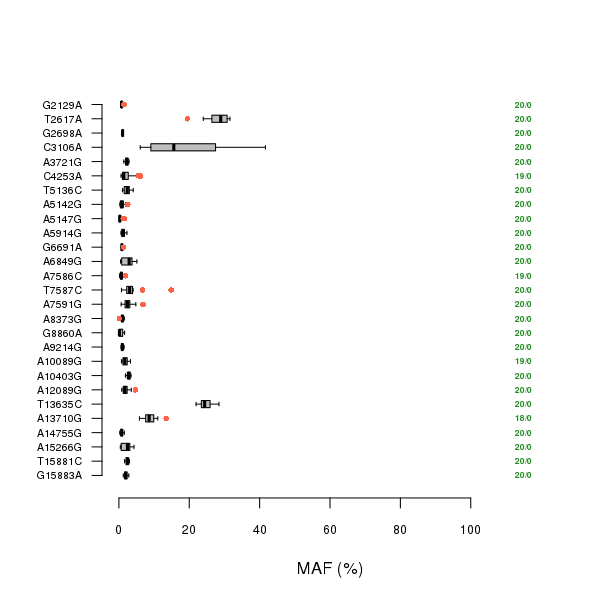

In [73]:
%%R -w 6 -h 6 -u in -r 100

par(oma=c(0,1,0,0))
CAXIS = 1 - (ncol(cleanbxData)/75)

boxplot(cleanbxData,las=1, frame=F, whisklty=1,col="grey",boxwex=0.5, xlab="MAF (%)",xlab="",
        cex.axis=CAXIS,pch=16,cex=0.75,outcol="tomato",ylim=c(0,120), names=cleanLabs,horizontal=T,xaxt="n")
axis(1,at=seq(0,100,20),cex.axis=0.75 )


# Count the number of sites > 1% per site
notna = apply(cleanbxData,2,FUN = function(x) sum(!(is.na(x))))
over = apply(cleanbxData,2,FUN = function(x) sum(!(is.na(x)) & (x)>=50))
    
for (i in 1:length(notna)){
  text(115,i,lab=paste(notna[i]-over[i],over[i],sep="/"),cex=0.5,font=2,col="forestgreen")
}

In [85]:
%%R
head(newdata)

      SRR353635 SRR353636 SRR353637 SRR353638 SRR353639 SRR353640 SRR353641
15883   0.02825   0.02308   0.01248   0.01510   0.01319   0.01418   0.02302
15881   0.02733   0.02613   0.02541   0.01875   0.02004   0.01616   0.02297
15266   0.00587   0.00471   0.00849   0.00610   0.00416   0.00407   0.00690
14755   0.01200   0.01542   0.00887   0.00846   0.01057   0.00822   0.00885
13710   0.08139   0.11050   0.13470   0.09911   0.07629   0.07143   0.10179
13635   0.28439   0.23403   0.22302   0.21944   0.23356   0.23715   0.23015
      SRR353642 SRR353643 SRR353644 SRR353645 SRR353646 SRR353647 SRR353648
15883   0.01820   0.01802   0.01919   0.02253   0.01981   0.02194   0.02193
15881   0.02061   0.02242   0.02373   0.02512   0.02722   0.02541   0.03007
15266   0.02636   0.02785   0.03137   0.03884   0.04280   0.03905   0.03071
14755   0.00962   0.00953   0.01135   0.00565   0.00353   0.00569   0.00583
13710   0.06287   0.05835   0.08724   0.08670   0.09057   0.07702   0.10881
13635   0.24

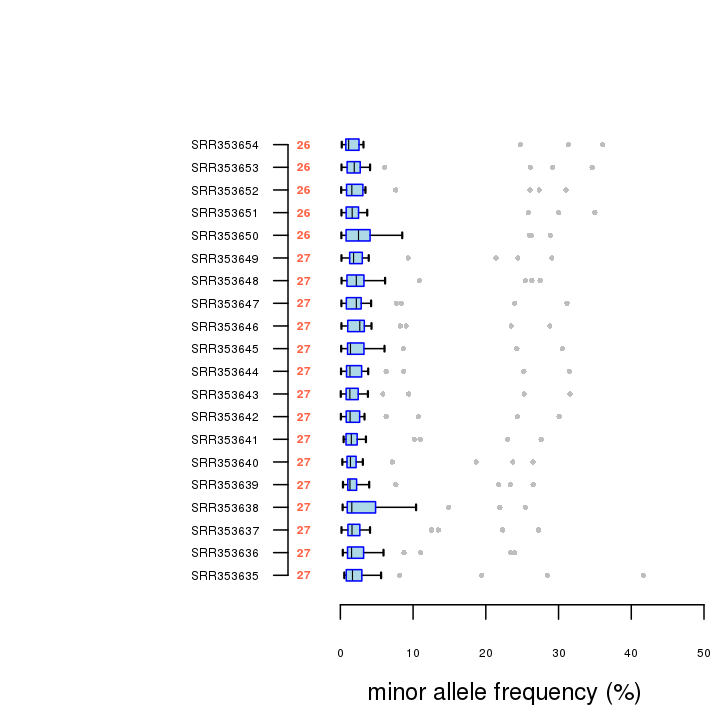

In [86]:
%%R -w 5 -h 5 -u in -r 144

# Minor allele distribution per time point, of unbiased sites, if the site >= 1%


newdata = t(cleanbxData/100)
nsites = apply(newdata, 2, FUN=function(x) sum(!(is.na(x))))
ordered = names(sort(nsites,decreasing=TRUE))

    
    
        
par(mar=c(4,10,4,0))
boxplot(
  #newdata[,ordered],
  newdata,
  pch=16,cex=0.5,
  outcol="grey",outline=T,
  whisklty=1,whiskwd=1,
  staplelwd=1.5,
  boxwex=0.5,boxcol="blue",boxfill="lightblue",
  horizontal=T,cex.axis=0.5,las=2,
  frame=F,xaxt="n",ylim=c(-0.05,0.5),
    medlwd=0.75
  )

axis(1,at=seq(0,5,1)/10,lab=100*(seq(0,5,1)/10),cex.axis=0.5)
title(xlab="minor allele frequency (%)",line=2.5,cex.axis=0.75)


for (i in 1:length(nsites)){
  text(-0.05,i,lab=nsites[ordered][i],cex=0.5,font=2,col="tomato")
}
#mtext("Nsites:",side=3,line=-1,at=0,adj=1.25,col="tomato")

In [76]:
%%R
summary(nsites)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  26.00   26.75   27.00   26.75   27.00   27.00 


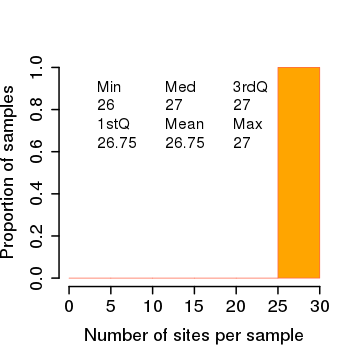

In [77]:
%%R -w 5 -h 5 -u in -r 72

par(oma=c(0,0,0,0))

h = hist(nsites, plot=FALSE,breaks=seq(0,30,5))

h$counts = h$counts/sum(h$counts)
plot(h,col="orange",lwd=2,border="tomato",cex.axis=1.5,cex.lab=1.5,ylim=c(0,1),main="",
     xlab="Number of sites per sample",ylab="Proportion of samples")
legend(0,1,legend=rbind(c("Min","1stQ","Med","Mean","3rdQ","Max"),summary(nsites)),bty="n",ncol=3,cex=1.3)

In [78]:
initial.head()

,position,major,minor,SRR353635,SRR353636,SRR353637,SRR353638,SRR353639,SRR353640,SRR353641,...,SRR353649,SRR353650,SRR353651,SRR353652,SRR353653,SRR353654,ptchange,class,ntchange,gene
0,2617,T,A,0.19433,0.23979,0.2724,0.25441,0.26505,0.26493,0.27597,...,0.29076,0.26255,0.30007,0.31012,0.29193,0.31339,-,rRNA,tv,RNR2
1,3721,A,G,0.01809,0.02555,0.02689,0.01918,0.0184,0.01632,0.02145,...,0.02309,0.02494,0.02355,0.02844,0.02108,0.02639,nonsyn,CDS,ts,ND1
2,8860,G,A,0.01625,0.01347,0.0077,0.00949,0.01219,0.01389,0.01511,...,0.00175,0.00136,0.0015,0.00134,0.00158,0.00192,syn,CDS,ts,ATP6
3,13635,T,C,0.28439,0.23403,0.22302,0.21944,0.23356,0.23715,0.23015,...,0.24393,0.25978,0.25862,0.27349,0.26099,0.24746,syn,CDS,ts,ND5
4,13710,A,G,0.08139,0.1105,0.1347,0.09911,0.07629,0.07143,0.10179,...,0.09329,0.08508,NA,0.07603,0.0608,NA,syn,CDS,ts,ND5


In [79]:
clean=initial

In [80]:
%R -i clean

In [81]:
%%R
NCOL = ncol(clean)
table(clean[,c(NCOL-1,NCOL-2,NCOL-3)])

, , ptchange = -

        class
ntchange CDS rRNA tRNA
      ts   0    2    0
      tv   0    2    1

, , ptchange = nonsyn

        class
ntchange CDS rRNA tRNA
      ts  13    0    0
      tv   1    0    0

, , ptchange = syn

        class
ntchange CDS rRNA tRNA
      ts   8    0    0
      tv   0    0    0



### average number of high quality sites per time point

In [82]:
%%R
summary(apply(clean[,4:(NCOL-4)],2,FUN=function(x) sum(x>=0.01)))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   15.0    17.0    18.5    18.3    20.0    21.0 
